In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
print("Loading dataset...")
housing_data = pd.read_csv("/content/BostonHousing.csv")
print("Dataset loaded successfully!\n")

Loading dataset...
Dataset loaded successfully!



In [ ]:
housing_data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [ ]:
housing_data.shape

(506, 14)

In [ ]:
housing_data.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat', 'medv'],
      dtype='object')

In [ ]:
housing_data.isnull().sum()

,0
crim,0
zn,0
indus,0
chas,0
nox,0
rm,0
age,0
dis,0
rad,0
tax,0


In [ ]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [ ]:
housing_data.dropna(inplace=True)

In [ ]:
housing_data['location_index'] = housing_data['rad'] * housing_data['tax']

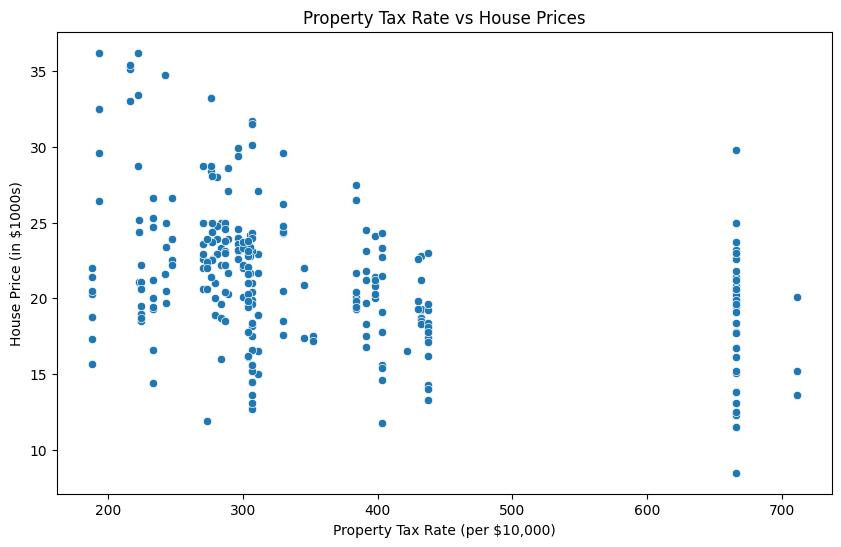

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=housing_data['tax'], y=housing_data['medv'])
plt.title("Property Tax Rate vs House Prices")
plt.xlabel("Property Tax Rate (per $10,000)")
plt.ylabel("House Price (in $1000s)")
plt.show()


In [ ]:
Q1 = housing_data.quantile(0.25)
Q3 = housing_data.quantile(0.75)
IQR = Q3 - Q1
housing_data = housing_data[~((housing_data < (Q1 - 1.5 * IQR)) | (housing_data > (Q3 + 1.5 * IQR))).any(axis=1)]

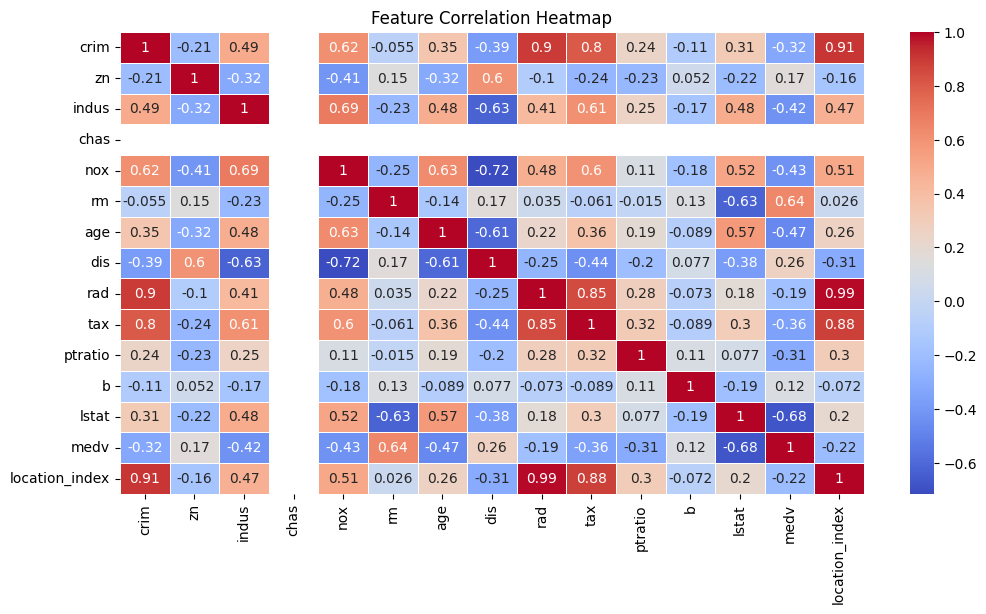

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(housing_data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

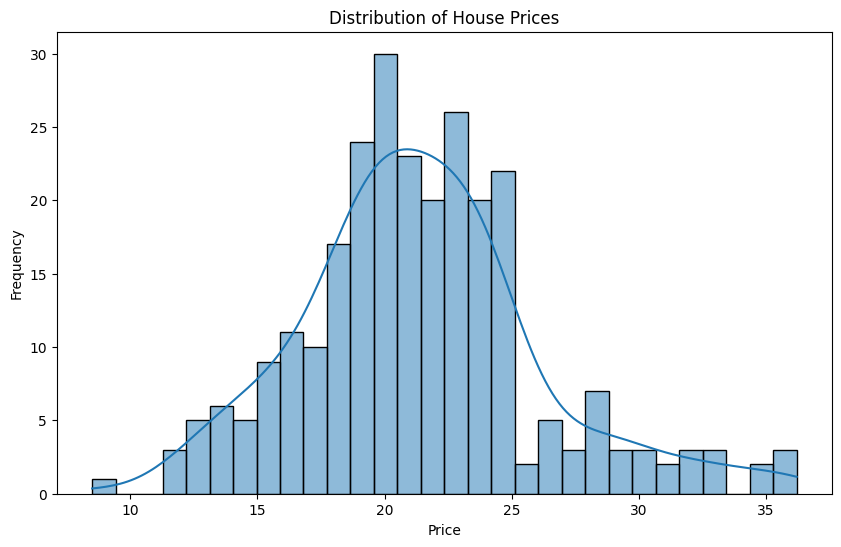

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(housing_data['medv'], bins=30, kde=True)
plt.title("Distribution of House Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

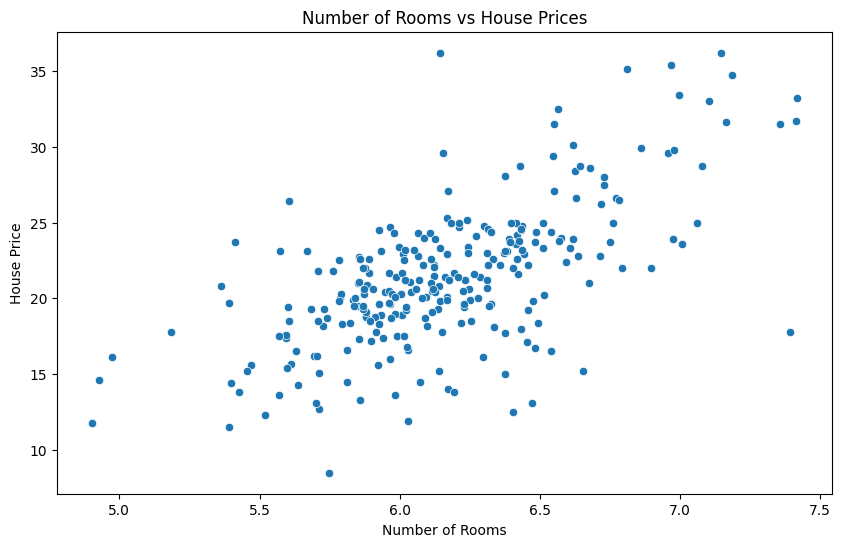

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=housing_data['rm'], y=housing_data['medv'])
plt.title("Number of Rooms vs House Prices")
plt.xlabel("Number of Rooms")
plt.ylabel("House Price")
plt.show()

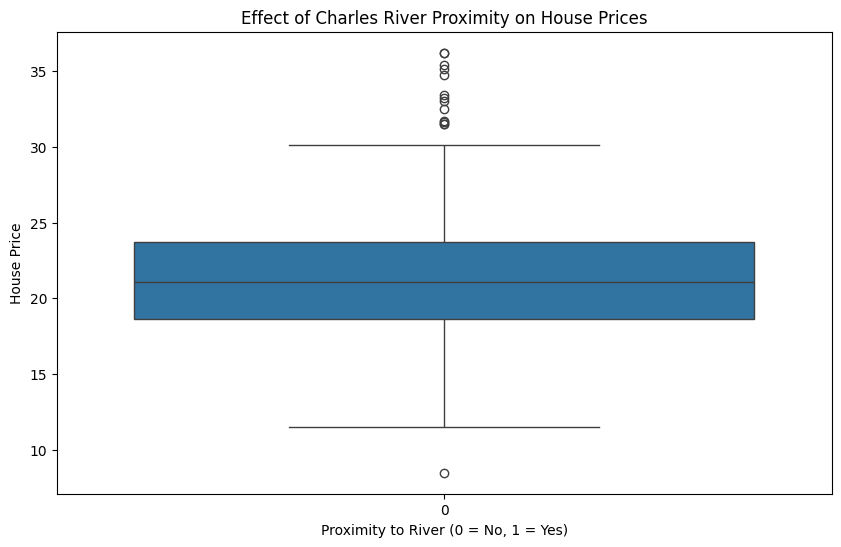

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=housing_data['chas'], y=housing_data['medv'])
plt.title("Effect of Charles River Proximity on House Prices")
plt.xlabel("Proximity to River (0 = No, 1 = Yes)")
plt.ylabel("House Price")
plt.show()

<Figure size 1000x600 with 0 Axes>

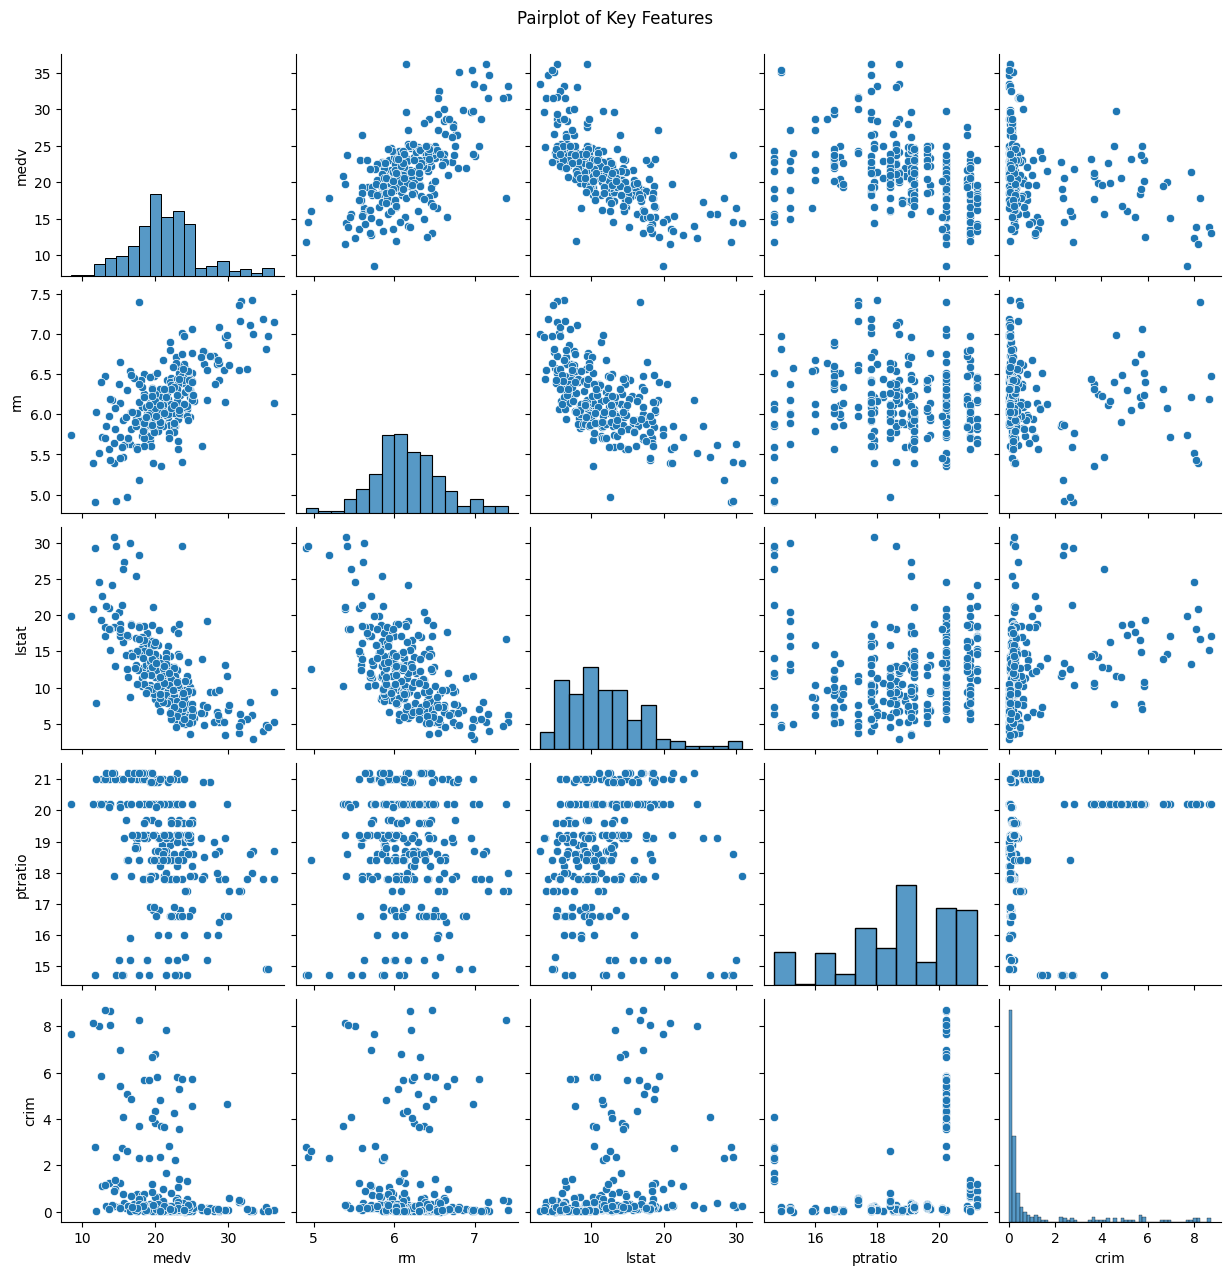

In [ ]:
plt.figure(figsize=(10, 6))
sns.pairplot(housing_data[['medv', 'rm', 'lstat', 'ptratio', 'crim']])
plt.suptitle("Pairplot of Key Features", y=1.02)
plt.show()

In [ ]:
X = housing_data.drop(columns=['medv'])
y = housing_data['medv']


In [ ]:
categorical_columns = X.select_dtypes(include=['object']).columns
for column in categorical_columns:
    X[column] = LabelEncoder().fit_transform(X[column])
print("Categorical features encoded!\n")


Categorical features encoded!



In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X = poly.fit_transform(X)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Data split into training and testing sets!\n")


Data split into training and testing sets!



In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("Feature scaling applied!\n")


Feature scaling applied!



In [ ]:
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "Linear Regression": LinearRegression(),
    "Support Vector Regressor": SVR()
}

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = {}
print("Performing cross-validation on models...\n")
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')
    cv_scores[model_name] = np.mean(scores)
    print(f"{model_name} Cross-Validated R2 Score: {np.mean(scores):.4f}")


Performing cross-validation on models...

Random Forest Cross-Validated R2 Score: 0.7127
Gradient Boosting Cross-Validated R2 Score: 0.7392
Linear Regression Cross-Validated R2 Score: -0.7082
Support Vector Regressor Cross-Validated R2 Score: 0.5430


In [ ]:
best_model_name = max(cv_scores, key=cv_scores.get)

In [ ]:
best_model = models[best_model_name]

In [ ]:
print(f"\nBest Model Based on Cross-Validation: {best_model_name}\n")



Best Model Based on Cross-Validation: Gradient Boosting



In [ ]:
if isinstance(best_model, (RandomForestRegressor, GradientBoostingRegressor)):
    print("Performing hyperparameter tuning for best model...")
    param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
    grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    print("Hyperparameter tuning completed!\n")

Performing hyperparameter tuning for best model...
Hyperparameter tuning completed!



In [ ]:
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


In [ ]:
print("Final Model Performance:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R2 Score: {r2}\n")


Final Model Performance:
Mean Absolute Error (MAE): 2.0524100408068082
Mean Squared Error (MSE): 7.221331300689612
Root Mean Squared Error (RMSE): 2.6872534864968753
R2 Score: 0.5798039547040044



Generating SHAP explanations...


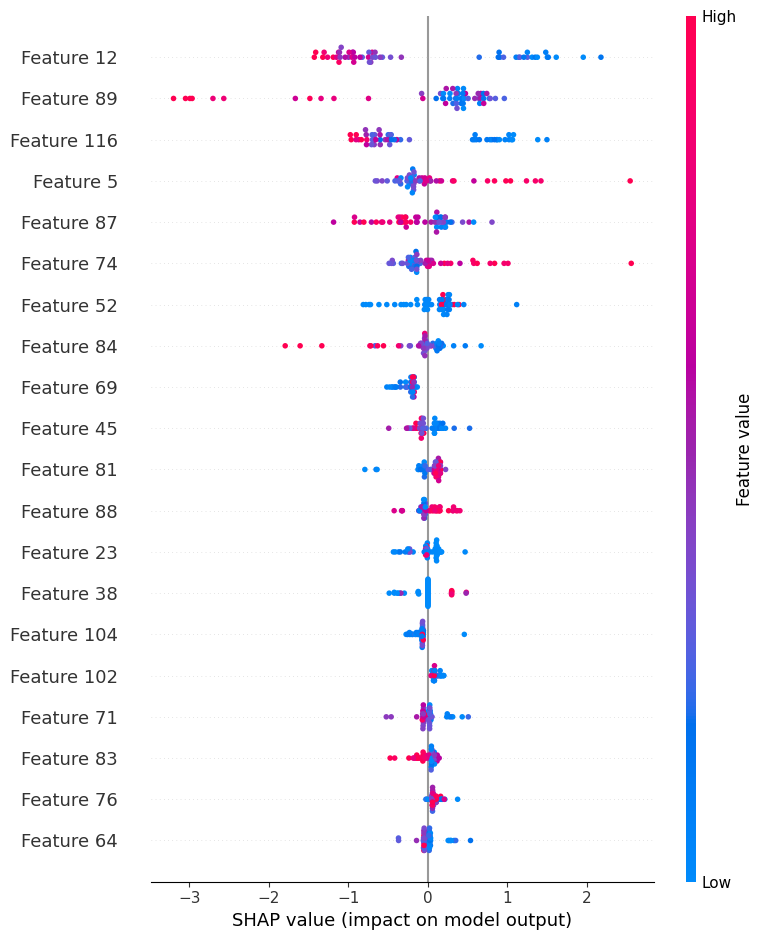

In [ ]:
print("Generating SHAP explanations...")
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)


In [ ]:
with open("best_house_price_model.pkl", "wb") as f:
    pickle.dump(best_model, f)


In [ ]:
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [ ]:
print("Model and scaler saved successfully!\n")


Model and scaler saved successfully!

